# 双节倒立摆 Acrobot-v1

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import scipy
import pandas as pd
import gym
import tensorflow as tf
from tensorflow import keras
try: # tf2
    tf.random.set_seed(0)
    from tensorflow.keras.initializers import GlorotUniform
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.optimizers import SGD
except: # tf1
    tf.enable_eager_execution()
    tf.random.set_random_seed(0)
    from tensorflow import glorot_uniform_initializer as GlorotUniform
    from tensorflow.train import AdamOptimizer as Adam
    from tensorflow.train import GradientDescentOptimizer as SGD
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)

[0]

### 用简单的执行者评论家算法寻找最优策略

In [3]:
class QActorCriticAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=keras.losses.categorical_crossentropy,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=self.action_n,
                **critic_kwargs)
    
    def build_network(self, hidden_sizes, output_size, input_size=None,
                activation=tf.nn.relu, output_activation=None,
                loss=keras.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for idx, hidden_size in enumerate(hidden_sizes):
            kwargs = {}
            if idx == 0 and input_size is not None:
                kwargs['input_shape'] = (input_size,)
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0), **kwargs))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, reward, next_observation, done):
        # 训练执行者网络
        x = observation[np.newaxis]
        u = self.critic_net.predict(x)
        q = u[0, action]
        x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)[0, action]
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor,
                    1e-6, 1.))
            loss_tensor = -self.discount * q * logpi_tensor
        grad_tensors = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(
                grad_tensors, self.actor_net.variables))
        
        # 训练评论者网络
        q = self.critic_net.predict(next_observation[np.newaxis])[0, action]
        u[0, action] = reward + (1. - done) * self.gamma * q
        self.critic_net.fit(x, u, verbose=0)
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

In [4]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    step = 0
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    done)
        if done:
            break
        step += 1
        observation = next_observation
    return episode_reward

平均回合奖励 = -9342.0 / 100 = -93.42


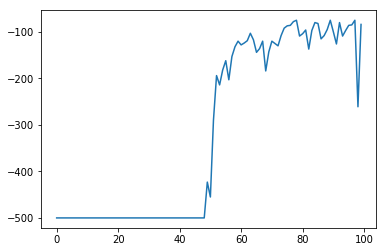

In [5]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0002}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0005}
agent = QActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

优势执行者/评论者算法

In [6]:
class AdvantageActorCriticAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                loss=keras.losses.categorical_crossentropy,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
    
    def learn(self, observation, action, reward, next_observation, done):
        x = observation[np.newaxis]
        u = reward + (1. - done) * self.gamma * \
                self.critic_net.predict(next_observation[np.newaxis])
        td_error = u - self.critic_net.predict(x)
        y = self.discount * td_error * \
                np.eye(self.action_n)[np.newaxis, action]
        self.actor_net.fit(x, y, verbose=0)
        self.critic_net.fit(x, u, verbose=0)
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

平均回合奖励 = -9867.0 / 100 = -98.67


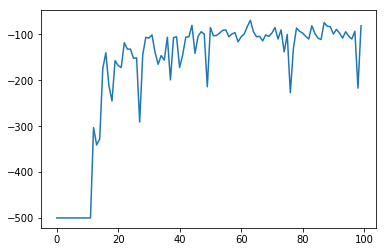

In [7]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0002}
agent = AdvantageActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

带资格迹的执行者/评论者算法

In [8]:
class ElibilityTraceActorCriticAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99,
            actor_lambda=0.9, critic_lambda=0.9):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.actor_lambda = actor_lambda
        self.critic_lambda = critic_lambda
        self.gamma = gamma
        self.discount = 1.

        self.actor_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, output_activation=tf.nn.softmax,
                **actor_kwargs)
        self.critic_net = self.build_network(input_size=observation_dim,
                output_size=1, **critic_kwargs)
        self.actor_traces = [np.zeros_like(weight) for weight in
                self.actor_net.get_weights()]
        self.critic_traces = [np.zeros_like(weight) for weight in
                self.critic_net.get_weights()]
    
    def learn(self, observation, action, reward, next_observation, done):
        q =  self.critic_net.predict(observation[np.newaxis])[0, 0]
        u = reward + (1. - done) * self.gamma * \
                self.critic_net.predict(next_observation[np.newaxis])[0, 0]
        td_error = u - q
        
        # 训练执行者网络
        x_tensor = tf.convert_to_tensor(observation[np.newaxis],
                dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)
            logpi_tensor = tf.math.log(tf.clip_by_value(pi_tensor, 1e-6, 1.))
            logpi_pick_tensor = logpi_tensor[0, action]
        grad_tensors = tape.gradient(logpi_pick_tensor,
                self.actor_net.variables)
        self.actor_traces = [self.gamma * self.actor_lambda * trace +
                self.discount * grad.numpy() for trace, grad in
                zip(self.actor_traces, grad_tensors)]
        actor_grads = [tf.convert_to_tensor(-td_error * trace,
                dtype=tf.float32) for trace in self.actor_traces]
        actor_grads_and_vars = tuple(zip(actor_grads,
                self.actor_net.variables))
        self.actor_net.optimizer.apply_gradients(actor_grads_and_vars)
        
        # 训练评论者网络
        with tf.GradientTape() as tape:
            v_tensor = self.critic_net(x_tensor)
        grad_tensors = tape.gradient(v_tensor, self.critic_net.variables)
        self.critic_traces = [self.gamma * self.critic_lambda * trace +
                self.discount* grad.numpy() for trace, grad in
                zip(self.critic_traces, grad_tensors)]
        critic_grads = [tf.convert_to_tensor(-td_error * trace,
                dtype=tf.float32) for trace in self.critic_traces]
        critic_grads_and_vars = tuple(zip(critic_grads,
                self.critic_net.variables))
        self.critic_net.optimizer.apply_gradients(critic_grads_and_vars)
        
        if done:
            # 下一回合重置资格迹
            self.actor_traces = [np.zeros_like(weight) for weight
                    in self.actor_net.get_weights()]
            self.critic_traces = [np.zeros_like(weight) for weight
                    in self.critic_net.get_weights()]
            # 为下一回合重置累积折扣
            self.discount = 1.
        else:
            self.discount *= self.gamma

平均回合奖励 = -8378.0 / 100 = -83.78


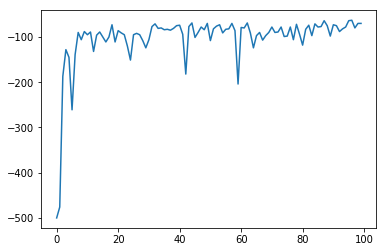

In [9]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.001}
agent = ElibilityTraceActorCriticAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)

# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 邻近策略优化

In [10]:
class PPOReplayer:
    def __init__(self):
        self.memory = pd.DataFrame()
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df], ignore_index=True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [11]:
class PPOAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs, clip_ratio=0.1,
            gamma=0.99, lambd=0.99, min_trajectory_length=1000,
            batches=1, batch_size=64):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.lambd = lambd
        self.clip_ratio = clip_ratio
        self.min_trajectory_length = min_trajectory_length
        self.batches = batches
        self.batch_size = batch_size
        
        self.trajectory = []
        self.replayer = PPOReplayer()
        
        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax,
                **actor_kwargs)
        self.critic_net = self.build_network(output_size=1,
                **critic_kwargs)
        
    def learn(self, observation, action, reward, done):
        self.trajectory.append((observation, action, reward))
        
        if done:
            df = pd.DataFrame(self.trajectory, columns=['observation',
                    'action', 'reward'])
            observations = np.stack(df['observation'])
            df['v'] = self.critic_net.predict(observations)
            pis = self.actor_net.predict(observations)
            df['pi'] = [pi[action] for pi, action in zip(pis,
                    df['action'])]
            
            df['next_v'] = df['v'].shift(-1).fillna(0.)
            df['u'] = df['reward'] + self.gamma * df['next_v']
            df['delta'] = df['u'] - df['v']
            df['return'] = df['reward']
            df['advantage'] = df['delta']
            for i in df.index[-2::-1]:
                df.loc[i, 'return'] += self.gamma * df.loc[i + 1, 'return']
                df.loc[i, 'advantage'] += self.gamma * self.lambd * \
                        df.loc[i + 1, 'advantage']
            fields = ['observation', 'action', 'pi', 'advantage', 'return']
            self.replayer.store(df[fields])
            self.trajectory = []
            
            if len(self.replayer.memory) > self.min_trajectory_length:
                for batch in range(self.batches):
                    observations, actions, pis, advantages, returns = \
                            self.replayer.sample(size=self.batch_size)

                    # 训练执行者
                    s_tensor = tf.convert_to_tensor(observations,
                            dtype=tf.float32)
                    gather_tensor = tf.convert_to_tensor([(i, a) for i, a
                            in enumerate(actions)], dtype=tf.int32)
                    pi_old_tensor = tf.convert_to_tensor(pis,
                            dtype=tf.float32)
                    advantage_tensor = tf.convert_to_tensor(advantages,
                            dtype=tf.float32)
                    with tf.GradientTape() as tape:
                        all_pi_tensor = self.actor_net(s_tensor)
                        pi_tensor = tf.gather_nd(all_pi_tensor,
                                gather_tensor)
                        surrogate_advantage_tensor = (pi_tensor /
                                pi_old_tensor) * advantage_tensor
                        clip_times_advantage_tensor = self.clip_ratio * \
                                surrogate_advantage_tensor
                        max_surrogate_advantage_tensor = advantage_tensor + \
                                tf.where(advantage_tensor > 0.,
                                clip_times_advantage_tensor,
                                -clip_times_advantage_tensor)
                        clipped_surrogate_advantage_tensor = tf.minimum(
                                surrogate_advantage_tensor,
                                max_surrogate_advantage_tensor)
                        loss_tensor = -tf.reduce_mean(
                                clipped_surrogate_advantage_tensor)
                    actor_grads = tape.gradient(loss_tensor,
                            self.actor_net.variables)
                    self.actor_net.optimizer.apply_gradients(
                            zip(actor_grads, self.actor_net.variables))
        
                    # 训练评论者
                    self.critic_net.fit(observations, returns, verbose=0)
                    
                self.replayer = PPOReplayer()

In [12]:
def play_montecarlo(env, agent, render=False, train=False):
    observation = env.reset()
    episode_reward = 0.
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, done)
        if done:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = -13711.0 / 100 = -137.11


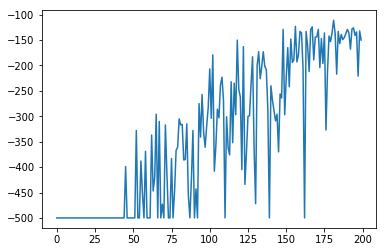

In [13]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.002}
agent = PPOAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs, batches=50)

# 训练
episodes = 200
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_montecarlo(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_montecarlo(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 异策算法

In [14]:
class OffPACAgent:
    def __init__(self, env, actor_kwargs, critic_kwargs, gamma=0.99):
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.discount = 1.
        self.critic_learning_rate = critic_kwargs['learning_rate']
        
        self.actor_net = self.build_network(output_size=self.action_n,
                output_activation=tf.nn.softmax, **actor_kwargs)
        self.critic_net = self.build_network(output_size=self.action_n,
                **critic_kwargs)
        
    def build_network(self, hidden_sizes, output_size,
                activation=tf.nn.relu, output_activation=None,
                loss=keras.losses.mse, learning_rate=0.01):
        model = keras.Sequential()
        for idx, hidden_size in enumerate(hidden_sizes):
            model.add(keras.layers.Dense(units=hidden_size,
                    activation=activation,
                    kernel_initializer=GlorotUniform(seed=0)))
        model.add(keras.layers.Dense(units=output_size,
                activation=output_activation,
                kernel_initializer=GlorotUniform(seed=0)))
        optimizer = SGD(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model
      
    def decide(self, observation):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        return action
        
    def learn(self, observation, action, behavior, reward,
            next_observation, done):
        observations = np.float32(observation[np.newaxis])
        pi = self.actor_net(observations)[0, action] # 用于训练评论者
        q = self.critic_net(observations)[0, action] # 用于训练执行者
        
        # 训练执行者
        x_tensor = tf.convert_to_tensor(observations, dtype=tf.float32)
        with tf.GradientTape() as tape:
            pi_tensor = self.actor_net(x_tensor)
            loss_tensor = -self.discount * q / behavior * pi_tensor[0, \
                    action]
        grad_tensors = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(zip(grad_tensors,
                self.actor_net.variables))
        
        # 训练评论者
        next_q = self.critic_net.predict(next_observation[np.newaxis])[0,
                action]
        u = reward + self.gamma * (1. - done) * next_q
        u_tensor = tf.convert_to_tensor(u, dtype=tf.float32)
        with tf.GradientTape() as tape:
            q_tensor = self.critic_net(x_tensor)
            mse_tensor = keras.losses.MSE(u_tensor, q_tensor)
            loss_tensor = pi / behavior * mse_tensor
        grad_tensors = tape.gradient(loss_tensor, self.critic_net.variables)
        self.critic_net.optimizer.apply_gradients(zip(grad_tensors,
                self.critic_net.variables))
        
        if done:
            self.discount = 1.
        else:
            self.discount *= self.gamma

In [15]:
class RandomAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        
    def decide(self, observation):
        action = np.random.choice(self.action_n)
        behavior = 1. / self.action_n
        return action, behavior

平均回合奖励 = -14293.0 / 100 = -142.93


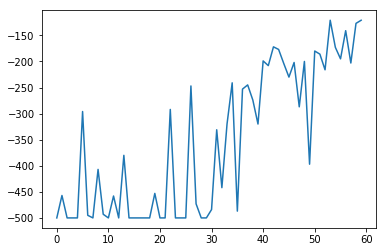

In [16]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0001}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.0001}
agent = OffPACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs)
behavior_agent = RandomAgent(env)

# 训练
episodes = 60
episode_rewards = []
for episode in range(episodes):
    observation = env.reset()
    episode_reward = 0.
    while True:
        action, behavior = behavior_agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        agent.learn(observation, action, behavior, reward,
                next_observation, done)
        if done:
            break
        observation = next_observation
    
    # 跟踪监控
    episode_reward = play_qlearning(env, agent)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 柔性执行者/评论者算法

In [17]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['observation', 'action', 'reward',
                'next_observation', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity
    
    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)
        
    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [18]:
class SACAgent(QActorCriticAgent):
    def __init__(self, env, actor_kwargs, critic_kwargs,
            gamma=0.99, alpha=0.2, net_learning_rate=0.1,
            replayer_capacity=1000, batches=1, batch_size=64):
        observation_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.net_learning_rate = net_learning_rate
        
        self.batches = batches
        self.batch_size = batch_size
        self.replayer = DQNReplayer(replayer_capacity)
        
        def sac_loss(y_true, y_pred):
            """ y_true 是 Q(*, action_n), y_pred 是 pi(*, action_n) """
            qs = alpha * tf.math.xlogy(y_pred, y_pred) - y_pred * y_true
            return tf.reduce_sum(qs, axis=-1)
        
        self.actor_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, output_activation=tf.nn.softmax,
                loss=sac_loss, **actor_kwargs)
        self.q0_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **critic_kwargs)
        self.q1_net = self.build_network(input_size=observation_dim,
                output_size=self.action_n, **critic_kwargs)
        self.v_evaluate_net = self.build_network(
                input_size=observation_dim, output_size=1, **critic_kwargs)
        self.v_target_net = self.build_network(
                input_size=observation_dim, output_size=1, **critic_kwargs)
        
        self.update_target_net(self.v_target_net, self.v_evaluate_net)
        
    def update_target_net(self, target_net, evaluate_net, learning_rate=1.):
        target_weights = target_net.get_weights()
        evaluate_weights = evaluate_net.get_weights()
        average_weights = [(1. - learning_rate) * t + learning_rate * e
                for t, e in zip(target_weights, evaluate_weights)]
        target_net.set_weights(average_weights)
        
    def learn(self, observation, action, reward, next_observation, done):
        self.replayer.store(observation, action, reward, next_observation,
                done)
        
        if done:
            for batch in range(self.batches):
                # 经验回放
                observations, actions, rewards, next_observations, \
                        dones = self.replayer.sample(self.batch_size)
                
                pis = self.actor_net.predict(observations)
                q0s = self.q0_net.predict(observations)
                q1s = self.q1_net.predict(observations)
                
                # 训练执行者
                self.actor_net.fit(observations, q0s, verbose=0)
                
                # 训练评论者
                q01s = np.minimum(q0s, q1s)
                entropic_q01s = pis * q01s - self.alpha * \
                        scipy.special.xlogy(pis, pis)
                v_targets = entropic_q01s.sum(axis=-1)
                self.v_evaluate_net.fit(observations, v_targets, verbose=0)
                
                next_vs = self.v_target_net.predict(next_observations)
                q_targets = rewards + self.gamma * (1. - dones) * \
                         next_vs[:, 0]
                q0s[range(self.batch_size), actions] = q_targets
                q1s[range(self.batch_size), actions] = q_targets
                self.q0_net.fit(observations, q0s, verbose=0)
                self.q1_net.fit(observations, q1s, verbose=0)
                
                # 更新目标网络
                self.update_target_net(self.v_target_net,
                        self.v_evaluate_net, self.net_learning_rate)

平均回合奖励 = -9196.0 / 100 = -91.96


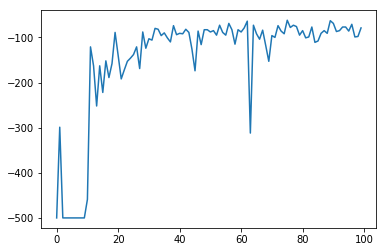

In [19]:
actor_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.01}
critic_kwargs = {'hidden_sizes' : [100,], 'learning_rate' : 0.01}
agent = SACAgent(env, actor_kwargs=actor_kwargs,
        critic_kwargs=critic_kwargs, batches=50)


# 训练
episodes = 100
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)    
plt.plot(episode_rewards);

# 测试
episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

In [20]:
env.close()